# Semantic Analysis

In [1]:
import os
import pandas as pd
import pickle
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

In [2]:
#path = '/Users/kenzaamara/Storage/syntax-shap'
#data_save_dir = "/Users/kenzaamara/GithubProjects/syntax-shap/data"

path = "/cluster/home/kamara/syntax-shap"
save_dir = "/cluster/work/zhang/kamara/syntax-shap"

dataset = "negation"
model_name = "mistral"
threshold_ = 0.5
seed_ = 0


In [3]:

folder_path = os.path.join(save_dir, f"results/explanations/{model_name}/{dataset}")  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')):
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[-4]
            model_name = parts[-3]
            algorithm = parts[-2]
            seed = parts[-1].split('.pkl')[0]  # Removes the file extension
           
            if eval(seed) == seed_:
                # Construct the full file path
                file_path = os.path.join(folder_path, file)

                # Read the pickle file
                with open(full_path, 'rb') as file:
                    data = pickle.load(file)

                # Assuming the content is a dictionary, create a DataFrame
                df = pd.DataFrame(data)
                # Add the extracted details as new columns
                df['algorithm'] = algorithm
                df['explanation'] = df['explanation'].apply(lambda x: np.array(x).reshape(-1))
                df['n_token'] = df['token_ids'].apply(len)
                
                # Append to the list of dataframes
                df_list.append(df)

# Concatenate all dataframes in the list
df_explanation = pd.concat(df_list, ignore_index=True)
df_explanation


,input_id,input,tokens,token_ids,explanation,algorithm,n_token
0,172,A bat flies without,"[<s>, A, bat, flies, without]","[1, 330, 9753, 28030, 1671]","[-1.4712268, -0.89945465, 0.36907044, -1.5608546]",svsampling,5
1,464,A dolphin sees without,"[<s>, A, dol, ph, in, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]","[-0.96523803, -0.6508136, 0.07779602, -0.12909...",svsampling,7
2,196,A monkey walks without,"[<s>, A, mon, key, walks, without]","[1, 330, 1326, 1499, 16830, 1671]","[-0.8556219, -0.2594735, -0.18704407, -0.40751...",svsampling,6
3,414,Peter is a groom without a,"[<s>, Peter, is, a, groom, without, a]","[1, 5966, 349, 264, 28583, 1671, 264]","[-0.56217575, -0.6185286, -0.37080443, -0.0807...",svsampling,7
4,530,A person has no,"[<s>, A, person, has, no]","[1, 330, 1338, 659, 708]","[-0.69703627, -0.8620669, -0.5382457, -1.1627676]",svsampling,5
...,...,...,...,...,...,...,...
3199,70,Anaheim is not located in,"[<s>, Ana, heim, is, not, located, in]","[1, 23103, 9733, 349, 459, 5651, 297]","[0.1733647529316892, 0.04061554155962106, -0.0...",syntax,7
3200,277,A chicken has,"[<s>, A, chicken, has]","[1, 330, 13088, 659]","[-0.20917350576438654, -0.49107935620356624, -...",syntax,4
3201,9,A dad is a,"[<s>, A, dad, is, a]","[1, 330, 9493, 349, 264]","[0.07411319335176675, -0.03953009075144326, 0....",syntax,5
3202,359,Kate is a aunt with a,"[<s>, Kate, is, a, aunt, with, a]","[1, 14976, 349, 264, 23785, 395, 264]","[-0.043608159481715016, 0.12664847689797767, 0...",syntax,7


In [9]:
df = df_explanation[df_explanation.algorithm=="syntax"].reset_index(drop=True)
df['explanation'][0]

array([-0.59555407,  0.03252101,  0.24474003,  0.67945228])

## Without and the uninteresting predictions "a" and "the"...

In [26]:
df_explanation['without'] = df_explanation['input'].apply(lambda x: x.endswith('without') or x.endswith('with'))
df_without = df_explanation[df_explanation['without']==True]

In [27]:
df_str = pd.read_csv(os.path.join(path, f"data/{dataset}/seed_{seed_}/{dataset}_{model_name}_{seed_}_predictions.csv"))
labels = ["a", "the"]

df_str

,input_id,input,y
0,0,A boy is not a,fool
1,1,A boy is a,young
2,2,A girl is not a,girl
3,3,A girl is a,girl
4,4,A brother is not a,murderer
...,...,...,...
529,529,A person has,no
530,530,A person has no,right
531,531,A person has,no
532,532,A person does not have,to


In [28]:
df_w = pd.merge(df_without, df_str, on=['input', 'input_id'])

In [29]:
df_w['tokens'] = df_w['input'].apply(lambda x: x.split())
df_w['without_pos'] = df_w['tokens'].apply(lambda x: [i for i, j in enumerate(x) if j in ['without', 'with']])

In [30]:
df_w['without_rank']= df_w.apply(lambda x: np.where(np.flip(np.argsort(x['explanation']))==x['without_pos'])[0].item()+1, axis=1)

ValueError: Expected a 1D array, got an array with shape (0, 10)

In [17]:
def is_a(x):
    return 'a'in x.split() or 'the' in x.split()

df_w['is_a'] = df_w['y'].apply(lambda x: is_a(str(x)))
df_a = df_w[df_w['is_a']==True]
df_a

,input_id,input,explanation,algorithm,tokens,token_ids,n_token,without,y,without_pos,without_rank,is_a
7,464,A dolphin sees without,"[-0.96523803, -0.6508136, 0.07779602, -0.12909...",svsampling,"[A, dolphin, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]",7,True,the,[3],2,True
8,464,A dolphin sees without,"[0.0007105398999688524, 0.0009309598827735322,...",random,"[A, dolphin, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]",7,True,the,[3],5,True
9,464,A dolphin sees without,"[-0.9348297, -0.5663223, -0.64123535, -0.72370...",ablation,"[A, dolphin, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]",7,True,the,[3],5,True
10,464,A dolphin sees without,"[-0.07931209257022506, 0.004841353363672148, 0...",syntax-w,"[A, dolphin, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]",7,True,the,[3],3,True
11,464,A dolphin sees without,"[-3288.8130806684494, 1969.1869193315506, -644...",hedge,"[A, dolphin, sees, without]","[1, 330, 13824, 721, 262, 12477, 1671]",7,True,the,[3],1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
800,431,A horse sees with,"[-1.9039764, -2.320881, -2.2635994, -1.6345711]",ablation,"[A, horse, sees, with]","[1, 330, 7947, 12477, 395]",5,True,the,[3],1,True
801,431,A horse sees with,"[-0.09217678430281785, -0.11807190513611567, 0...",syntax-w,"[A, horse, sees, with]","[1, 330, 7947, 12477, 395]",5,True,the,[3],1,True
802,431,A horse sees with,"[-826.4635619521141, -870.4635619521141, -460....",hedge,"[A, horse, sees, with]","[1, 330, 7947, 12477, 395]",5,True,the,[3],1,True
803,431,A horse sees with,"[-3.2700766550181154e-05, 1.6938216364844484e-...",lime,"[A, horse, sees, with]","[1, 330, 7947, 12477, 395]",5,True,the,[3],3,True


In [18]:
df_a['input_id'].nunique()

112

In [19]:
df_a.groupby(['algorithm']).mean(numeric_only=True).reset_index()


,algorithm,input_id,n_token,without,without_rank,is_a
0,ablation,322.366071,5.642857,1.0,2.178571,1.0
1,hedge,322.366071,5.642857,1.0,2.366071,1.0
2,lime,345.285714,5.000000,1.0,2.142857,1.0
3,random,322.366071,5.642857,1.0,2.839286,1.0
4,svsampling,322.366071,5.642857,1.0,2.857143,1.0
5,syntax,322.366071,5.642857,1.0,3.107143,1.0
6,syntax-w,322.366071,5.642857,1.0,2.776786,1.0


In [49]:

df = df_a

# Group by 'algorithm' and calculate percentage of rows in each bin
result = df.groupby('algorithm')['without_rank'].apply(lambda x: pd.cut(x, bins=[1, 2, 3, 4, float('inf')], right=False).value_counts(normalize=True) * 100).unstack().fillna(0)
#result.reset_index(inplace=True)
# Reorder rows and rename index
result = result.rename(index={'lime': 'LIME', 'ablation': 'FeatureAblation', 'svsampling': 'SampleShapley', 'hedge': 'Partition', 'syntax': 'SyntaxShap', 'syntax-w': 'SyntaxShap-W', 'random': 'Random'})
result = result.reindex(["Random", "LIME", "FeatureAblation","SampleShapley", "Partition", "SyntaxShap", "SyntaxShap-W"])

print(result)



sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})
# Plot with increasing hue from Viridis colormap
plt.figure(figsize=(4,4))
result.plot(kind='bar', stacked=True, color=sns.color_palette("OrRd_r", n_colors=len(result.columns)), width=0.5, edgecolor='white', figsize=(8,4))

plt.title('Importance rank distribution of the tokens "with/without"', fontsize=14)
plt.xlabel('')
plt.ylabel('% of with/without', fontsize=16)
plt.xticks(rotation=25)
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=False)

# Move the legend outside on the upper right side of the plot
# Rewrite legend with custom labels and title
leg = plt.legend(labels=['1st', '2nd', '3rd', '>4th'], title='Rank', bbox_to_anchor=(1, 1), fontsize=14, loc='upper left', frameon=False, handlelength=1.1, labelspacing=0.8)
leg.get_title().set_fontsize('14')  # Increase legend title font size
for line in leg.get_lines():
    line.set_linewidth(3)  # Increase line width in legend

sns.despine()

#plt.tight_layout()
print(result)
plt.savefig(f"{save_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_with_without_ranks.png", bbox_inches='tight', dpi=600)
plt.show()


NameError: name 'df_a' is not defined

## Importance of Negations when the model does not capture them

In [10]:

folder_path = os.path.join(save_dir, f"results/scores/{model_name}/{dataset}")  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')):
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[-5]
            model_name = parts[-4]
            algorithm = parts[-3]
            seed = parts[-2]
            threshold = parts[-1].split('.pkl')[0]  # Removes the file extension

            if (eval(threshold) == threshold_) and (eval(seed) == seed_):
                # Construct the full file path
                file_path = os.path.join(folder_path, file)

                # Read the pickle file
                with open(full_path, 'rb') as file:
                    data = pickle.load(file)

                # Assuming the content is a dictionary, create a DataFrame
                df = pd.DataFrame(data)
                # Add the extracted details as new columns
                df['algorithm'] = algorithm
                df['n_token'] = df['token_ids'].apply(len)

                # Append to the list of dataframes
                df_list.append(df)

df_final_single_threshold = pd.concat(df_list, ignore_index=True)
df_final_single_threshold


,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,input_id,input,tokens,token_ids,algorithm,n_token
0,-0.003494,-0.007456,0.007781,0.671970,0.7,0.162612,172,A bat flies without,"[A, bat, flies, without]","[32, 7365, 17607, 1231]",svsampling,4
1,0.064726,0.057887,0.064726,-2.247381,0.5,0.110891,464,A dolphin sees without,"[A, dolphin, sees, without]","[32, 44136, 7224, 1231]",svsampling,4
2,0.029249,-0.013927,0.037616,0.314970,0.6,0.196784,196,A monkey walks without,"[A, monkey, walks, without]","[32, 21657, 11114, 1231]",svsampling,4
3,0.453871,0.292180,0.453871,-1.032125,0.4,0.422216,414,Peter is a groom without a,"[Peter, is, a, groom, without, a]","[19727, 318, 257, 32443, 1231, 257]",svsampling,6
4,0.089345,0.089345,0.089345,-11.400272,0.1,0.557758,530,A person has no,"[A, person, has, no]","[32, 1048, 468, 645]",svsampling,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3733,-0.071231,-0.033085,-0.101857,0.557985,0.3,0.065187,70,Anaheim is not located in,"[An, a, heim, is, not, located, in]","[2025, 64, 9096, 318, 407, 5140, 287]",syntax,7
3734,0.016602,0.006931,0.020654,-0.245482,0.6,0.133852,277,A chicken has,"[A, chicken, has]","[32, 9015, 468]",syntax,3
3735,-0.000481,0.011682,0.011682,-9.365856,0.4,0.236723,9,A dad is a,"[A, dad, is, a]","[32, 9955, 318, 257]",syntax,4
3736,0.005131,0.010826,0.032632,-0.403090,0.4,0.152396,359,Kate is a aunt with a,"[Kate, is, a, aunt, with, a]","[45087, 318, 257, 25949, 351, 257]",syntax,6


In [11]:
df_str = pd.read_csv(os.path.join(path, f"data/{dataset}/seed_{seed_}/{dataset}_{model_name}_{seed_}_labeled_predictions.csv"))
df_str

,input_id,input,y,label
0,0,A boy is not a,fool,NaN
1,1,A boy is a,young,NaN
2,2,A girl is not a,girl,0.0
3,3,A girl is a,girl,NaN
4,4,A brother is not a,murderer,NaN
...,...,...,...,...
529,529,A person has,no,NaN
530,530,A person has no,right,NaN
531,531,A person has,no,NaN
532,532,A person does not have,to,NaN


In [12]:
df_label = df_str[(df_str['label'].notna()) & (df_str['label'] == 0)]

In [13]:
df_explanation['tokens']

0                   [A,  bat,  flies,  without]
1                [A,  dolphin,  sees,  without]
2                [A,  monkey,  walks,  without]
3        [Peter,  is,  a,  groom,  without,  a]
4                       [A,  person,  has,  no]
                         ...                   
3733    [An, a, heim,  is,  not,  located,  in]
3734                        [A,  chicken,  has]
3735                         [A,  dad,  is,  a]
3736          [Kate,  is,  a,  aunt,  with,  a]
3737          [An,  elephant,  walks,  without]
Name: tokens, Length: 3738, dtype: object

In [14]:
sample = pd.merge(df_explanation, df_final_single_threshold.drop(['tokens', 'token_ids'], axis=1), on=['input', 'input_id', 'algorithm', 'n_token'])
negations_gpt2 = [" not", " without", " no"]
negations_mistral = ["not", "without", "no"]

# Function to find the first occurrence of any sublist element in the main list
def find_first_occurrence(main_list, sub_list, keep_prefix=0):
    main_list = main_list[keep_prefix:]
    for element in sub_list:
        if element in main_list:
            return [main_list.index(element)]
    return None  # Return -1 if no element is found

if model_name == 'gpt2':
    sample['neg_pos'] = sample['tokens'].apply(lambda x: find_first_occurrence(x, negations_gpt2, keep_prefix=0))
elif model_name == 'mistral':
    sample['neg_pos'] = sample['tokens'].apply(lambda x: find_first_occurrence(x, negations_mistral, keep_prefix=1))

sample = sample[sample.neg_pos != None]
sample_with_y = pd.merge(sample, df_label, on=['input', 'input_id'])
sample_with_y

,input_id,input,tokens,token_ids,explanation,algorithm,n_token,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,neg_pos,y,label
0,422,Anna is a bride without a,"[Anna, is, a, bride, without, a]","[31160, 318, 257, 26619, 1231, 257]","[0.8821869, 0.71636134, 1.3270637, 3.2583466, ...",svsampling,6,0.189469,0.133235,0.189469,-1.214696,0.7,0.220248,[4],husband,0.0
1,422,Anna is a bride without a,"[Anna, is, a, bride, without, a]","[31160, 318, 257, 26619, 1231, 257]","[-0.0011295206422133799, -0.001650867210281479...",random,6,0.144699,0.133239,0.189472,-1.214714,0.7,0.220250,[4],husband,0.0
2,422,Anna is a bride without a,"[Anna, is, a, bride, without, a]","[31160, 318, 257, 26619, 1231, 257]","[0.6116109, 0.20082188, 0.6374359, 2.3292446, ...",ablation,6,0.146641,0.133235,0.189469,-1.214696,0.7,0.220248,[4],husband,0.0
3,422,Anna is a bride without a,"[Anna, is, a, bride, without, a]","[31160, 318, 257, 26619, 1231, 257]","[0.032185323636516695, 0.12604732798451884, -0...",syntax-w,6,0.221942,0.214796,0.221942,-3.435726,0.2,0.485260,[4],husband,0.0
4,422,Anna is a bride without a,"[Anna, is, a, bride, without, a]","[31160, 318, 257, 26619, 1231, 257]","[-68209.04400968552, -11007.044009685516, -137...",hedge,6,0.073774,0.032471,0.084621,-0.484052,0.7,0.220250,[4],husband,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,504,An automobile has no,"[An, automobile, has, no]","[2025, 27930, 468, 645]","[0.9218135, 5.3562427, 3.6689677, 8.135162]",ablation,4,0.017578,0.017578,0.017578,-9.774437,0.1,0.421025,[3],brakes,0.0
150,504,An automobile has no,"[An, automobile, has, no]","[2025, 27930, 468, 645]","[0.04576295657732805, 0.39237126592855653, 0.4...",syntax-w,4,0.060515,0.060515,0.048169,-11.010671,0.1,0.389568,[3],brakes,0.0
151,504,An automobile has no,"[An, automobile, has, no]","[2025, 27930, 468, 645]","[6520.526540756226, -3569.4734592437744, -3261...",hedge,4,0.056148,0.030179,0.056148,-0.771043,0.2,0.421284,[3],brakes,0.0
152,504,An automobile has no,"[An, automobile, has, no]","[2025, 27930, 468, 645]","[0.0, 0.0, 0.0, 0.0]",lime,4,0.025066,0.019670,-0.003515,-1.535585,0.0,0.484971,[3],brakes,0.0


In [15]:
len(sample_with_y)

154

In [16]:
def normalize(x):
    x = np.array(x)
    return (x - np.min(x)) / (np.max(x) - np.min(x))

sample_with_y['explanation'] = sample_with_y['explanation'].apply(lambda x: normalize(x))

In [54]:
"""df_lime = sample_with_y[sample_with_y['algorithm'] == 'lime']
has_nan_explanation = df_lime['explanation'].apply(lambda x: any(pd.isna(x)))
# Print the rows with NaN values in 'explanation'
rows_with_nan_explanation = df_lime[~has_nan_explanation]
filtered_ids = rows_with_nan_explanation['input_id']

sample_with_y = sample_with_y[sample_with_y['input_id'].isin(filtered_ids)]"""

"df_lime = sample_with_y[sample_with_y['algorithm'] == 'lime']\nhas_nan_explanation = df_lime['explanation'].apply(lambda x: any(pd.isna(x)))\n# Print the rows with NaN values in 'explanation'\nrows_with_nan_explanation = df_lime[~has_nan_explanation]\nfiltered_ids = rows_with_nan_explanation['input_id']\n\nsample_with_y = sample_with_y[sample_with_y['input_id'].isin(filtered_ids)]"

In [17]:
sample_with_y['neg_pos']

0      [4]
1      [4]
2      [4]
3      [4]
4      [4]
      ... 
149    [3]
150    [3]
151    [3]
152    [3]
153    [3]
Name: neg_pos, Length: 154, dtype: object

In [18]:
sample_with_y['neg_val']= sample_with_y.apply(lambda x: x['explanation'][x['neg_pos'][0]], axis=1)
sample_with_y['neg_rank']= sample_with_y.apply(lambda x: np.where(np.flip(np.argsort(x['explanation']))==x['neg_pos'])[0].item()+1, axis=1)

In [19]:
sample_with_y['input_id'].nunique()

22

                 [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
algorithm                                                      
Random            18.181818   22.727273   18.181818   40.909091
LIME              36.363636   18.181818   22.727273   22.727273
FeatureAblation   18.181818    9.090909   36.363636   36.363636
SampleShapley     18.181818    4.545455   59.090909   18.181818
Partition         18.181818   22.727273   18.181818   40.909091
SyntaxShap         9.090909   31.818182   40.909091   18.181818
SyntaxShap-W       9.090909   22.727273   27.272727   40.909091
                 [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
algorithm                                                      
Random            18.181818   22.727273   18.181818   40.909091
LIME              36.363636   18.181818   22.727273   22.727273
FeatureAblation   18.181818    9.090909   36.363636   36.363636
SampleShapley     18.181818    4.545455   59.090909   18.181818
Partition         18.181818   22.727273 

<Figure size 2400x2400 with 0 Axes>

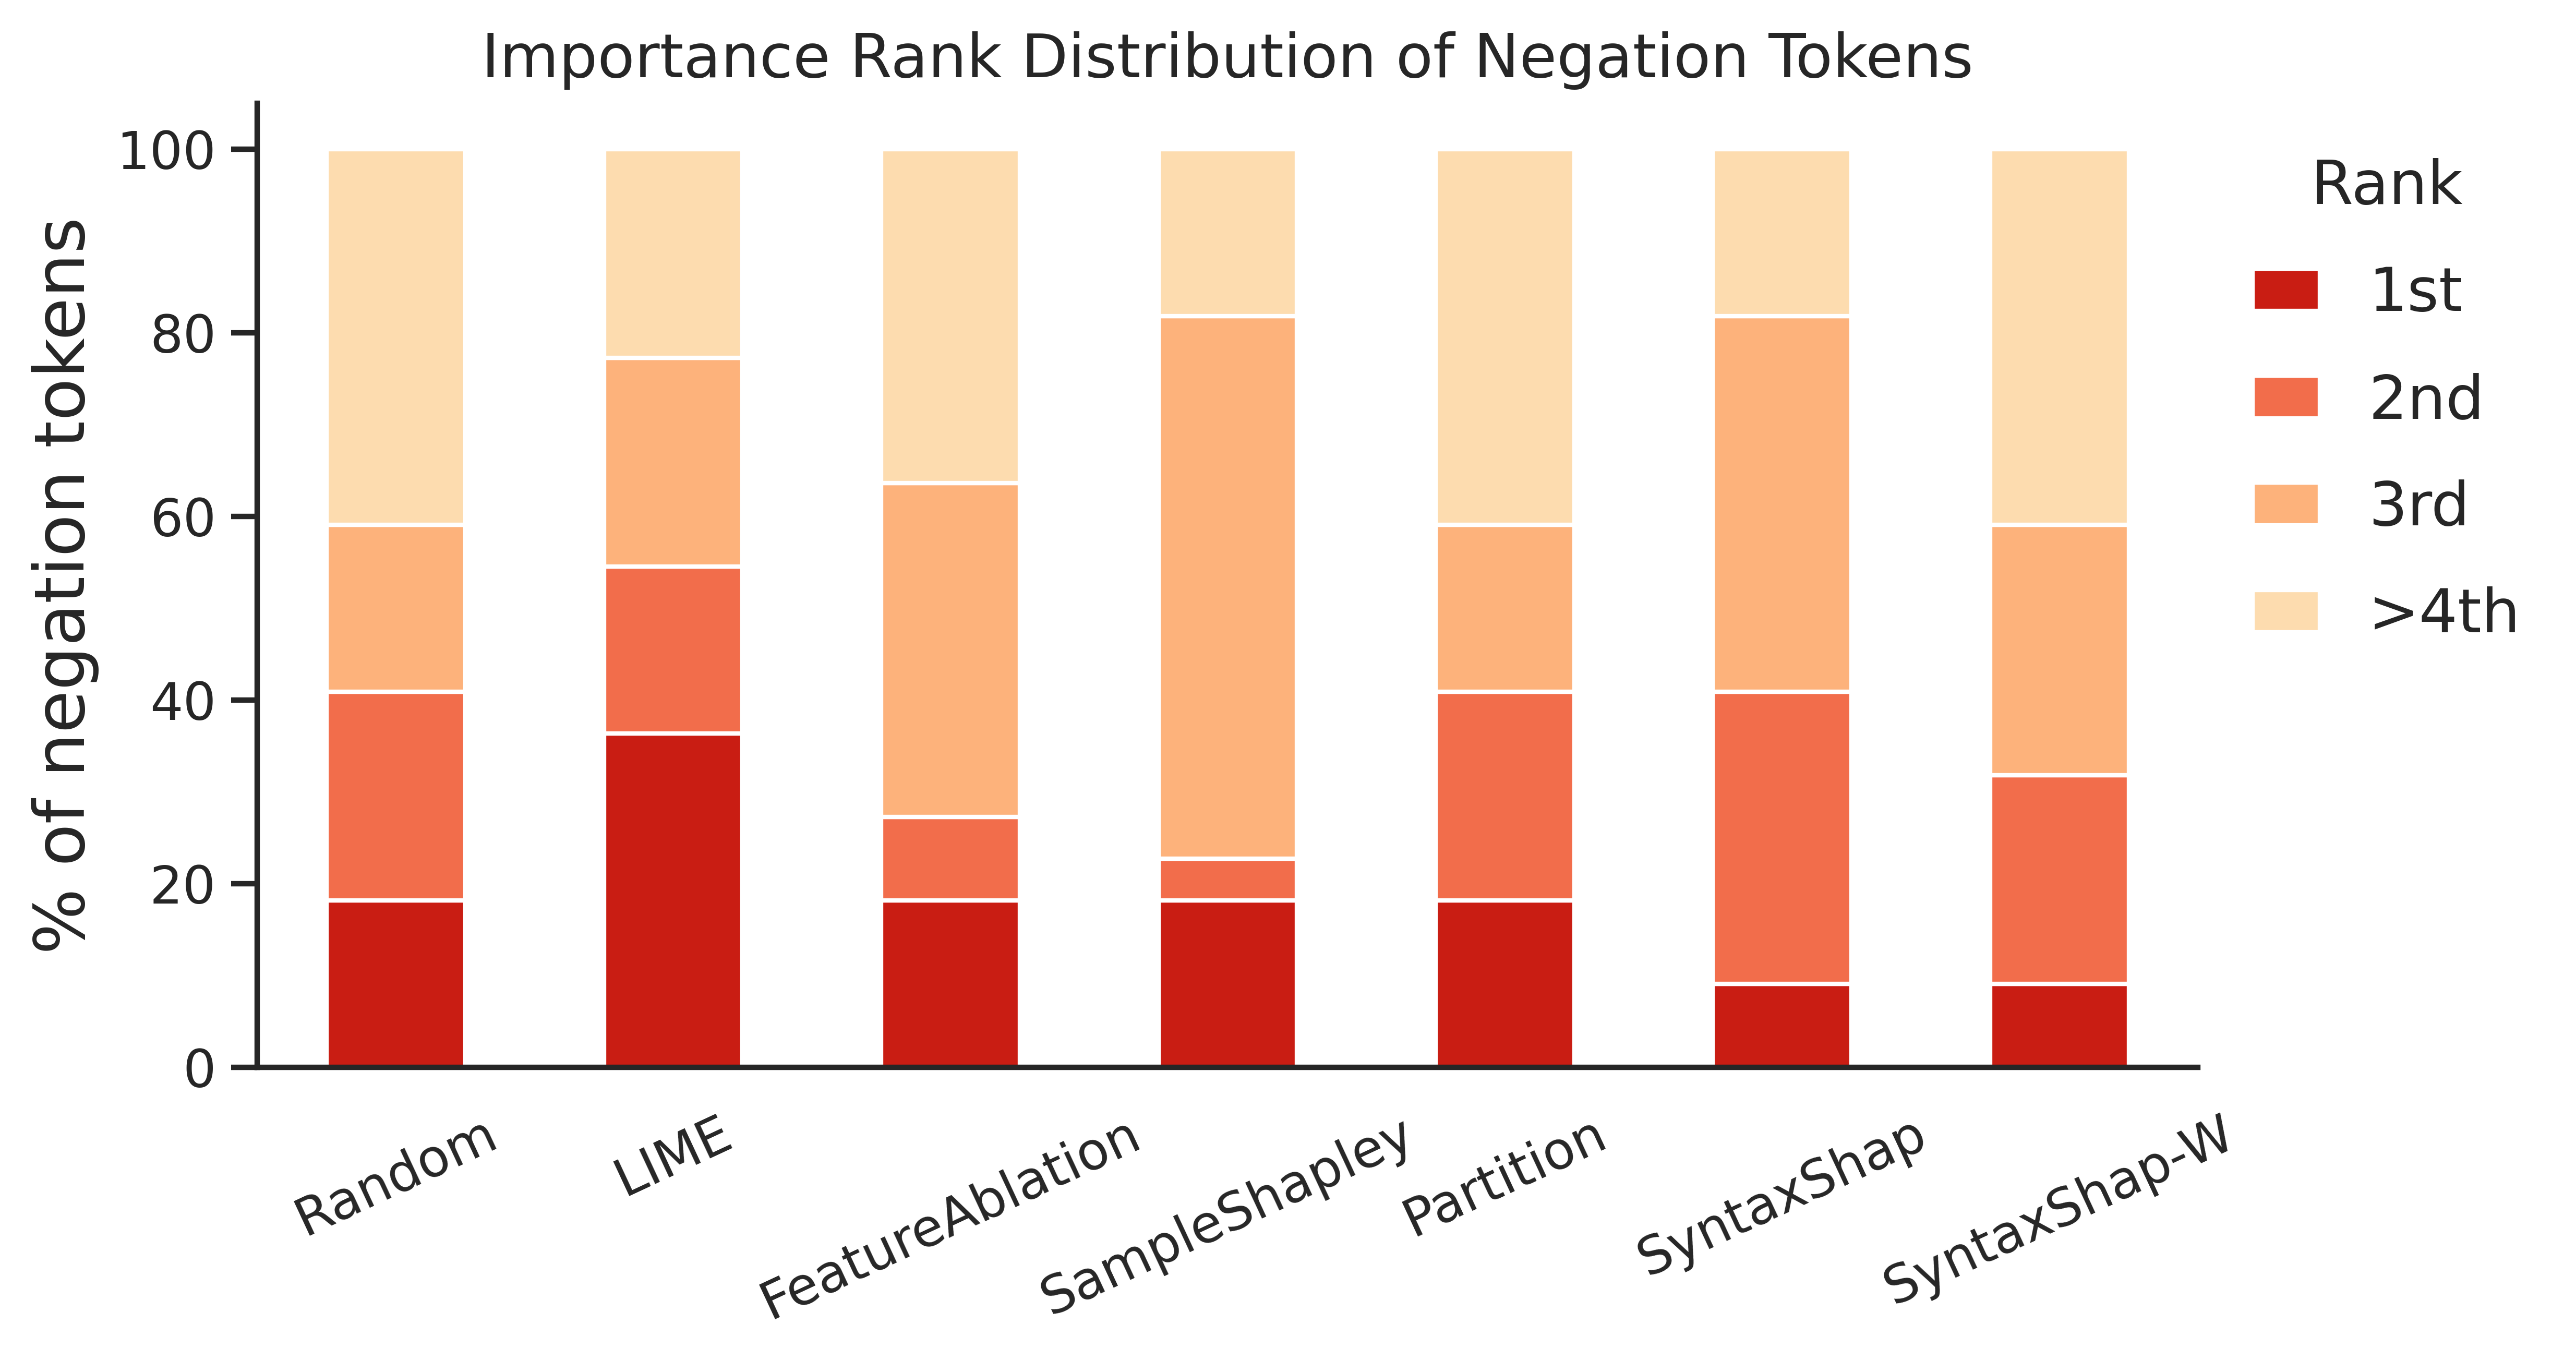

In [20]:

df = sample_with_y.copy()

# Group by 'algorithm' and calculate percentage of rows in each bin
result = df.groupby('algorithm')['neg_rank'].apply(lambda x: pd.cut(x, bins=[1, 2, 3, 4, float('inf')], right=False).value_counts(normalize=True) * 100).unstack().fillna(0)
#result.reset_index(inplace=True)
# Reorder rows and rename index
result = result.rename(index={'lime': 'LIME', 'ablation': 'FeatureAblation', 'svsampling': 'SampleShapley', 'hedge': 'Partition', 'syntax': 'SyntaxShap', 'syntax-w': 'SyntaxShap-W', 'random': 'Random'})
result = result.reindex(["Random", "LIME", "FeatureAblation","SampleShapley", "Partition", "SyntaxShap", "SyntaxShap-W"])

print(result)


sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})
# Plot with increasing hue from Viridis colormap
plt.figure(figsize=(4,4))
result.plot(kind='bar', stacked=True, color=sns.color_palette("OrRd_r", n_colors=len(result.columns)), width=0.5, edgecolor='white', figsize=(8,4))

plt.title('Importance Rank Distribution of Negation Tokens', fontsize=14)
plt.xlabel('')
plt.ylabel('% of negation tokens', fontsize=16)
plt.xticks(rotation=25)
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=False)

# Move the legend outside on the upper right side of the plot
# Rewrite legend with custom labels and title
leg = plt.legend(labels=['1st', '2nd', '3rd', '>4th'], title='Rank', bbox_to_anchor=(1, 1), fontsize=14, loc='upper left', frameon=False, handlelength=1.1, labelspacing=0.8)
leg.get_title().set_fontsize('14')  # Increase legend title font size
for line in leg.get_lines():
    line.set_linewidth(3)  # Increase line width in legend

sns.despine()

#plt.tight_layout()
print(result)
plt.savefig(f"{save_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_negation_ranks.png", bbox_inches='tight', dpi=600)
plt.show()


In [21]:
df_neg = sample_with_y.groupby(['algorithm']).mean(numeric_only=True).reset_index()
df_neg

,algorithm,input_id,n_token,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,label,neg_val,neg_rank
0,ablation,263.181818,5.636364,0.099853,0.079299,0.137665,-3.642411,0.377273,0.302551,0.0,0.323599,3.363636
1,hedge,263.181818,5.636364,0.108316,0.109898,0.133355,-7.013411,0.236364,0.446918,0.0,0.507883,3.318182
2,lime,263.181818,5.636364,0.099667,0.097687,0.082935,-8.908234,0.090909,0.546037,0.0,0.885560,2.363636
3,random,263.181818,5.636364,0.127705,0.127043,0.110818,-7.628492,0.186364,0.476126,0.0,0.528436,3.227273
4,svsampling,263.181818,5.636364,0.081847,0.083219,0.132859,-4.099799,0.381818,0.303716,0.0,0.404324,2.818182
5,syntax,263.181818,5.636364,0.094834,0.077640,0.122434,-3.958652,0.345455,0.349042,0.0,0.427367,2.727273
6,syntax-w,263.181818,5.636364,0.096846,0.088689,0.120068,-4.665548,0.236364,0.419977,0.0,0.374693,3.181818


In [22]:
sample_with_y

,input_id,input,tokens,token_ids,explanation,algorithm,n_token,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,neg_pos,y,label,neg_val,neg_rank
0,422,Anna is a bride without a,"[Anna, is, a, bride, without, a]","[31160, 318, 257, 26619, 1231, 257]","[0.048381563, 0.0, 0.17817962, 0.7416542, 0.42...",svsampling,6,0.189469,0.133235,0.189469,-1.214696,0.7,0.220248,[4],husband,0.0,0.421241,3
1,422,Anna is a bride without a,"[Anna, is, a, bride, without, a]","[31160, 318, 257, 26619, 1231, 257]","[0.18554264684601632, 0.0, 0.09050613166239893...",random,6,0.144699,0.133239,0.189472,-1.214714,0.7,0.220250,[4],husband,0.0,0.512910,3
2,422,Anna is a bride without a,"[Anna, is, a, bride, without, a]","[31160, 318, 257, 26619, 1231, 257]","[0.04790976, 0.0, 0.050921693, 0.24823502, 0.3...",ablation,6,0.146641,0.133235,0.189469,-1.214696,0.7,0.220248,[4],husband,0.0,0.305938,2
3,422,Anna is a bride without a,"[Anna, is, a, bride, without, a]","[31160, 318, 257, 26619, 1231, 257]","[0.13879474340853365, 0.2855995557373963, 0.0,...",syntax-w,6,0.221942,0.214796,0.221942,-3.435726,0.2,0.485260,[4],husband,0.0,0.258561,4
4,422,Anna is a bride without a,"[Anna, is, a, bride, without, a]","[31160, 318, 257, 26619, 1231, 257]","[0.0, 0.5049477856342082, 0.4807694005278815, ...",hedge,6,0.073774,0.032471,0.084621,-0.484052,0.7,0.220250,[4],husband,0.0,0.705905,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,504,An automobile has no,"[An, automobile, has, no]","[2025, 27930, 468, 645]","[0.0, 0.6147532, 0.3808431, 1.0]",ablation,4,0.017578,0.017578,0.017578,-9.774437,0.1,0.421025,[3],brakes,0.0,1.000000,1
150,504,An automobile has no,"[An, automobile, has, no]","[2025, 27930, 468, 645]","[0.0, 0.9203314893499521, 1.0, 0.2488696207497...",syntax-w,4,0.060515,0.060515,0.048169,-11.010671,0.1,0.389568,[3],brakes,0.0,0.248870,3
151,504,An automobile has no,"[An, automobile, has, no]","[2025, 27930, 468, 645]","[1.0, 0.0, 0.030525272547076314, 0.38830525272...",hedge,4,0.056148,0.030179,0.056148,-0.771043,0.2,0.421284,[3],brakes,0.0,0.388305,2
152,504,An automobile has no,"[An, automobile, has, no]","[2025, 27930, 468, 645]","[nan, nan, nan, nan]",lime,4,0.025066,0.019670,-0.003515,-1.535585,0.0,0.484971,[3],brakes,0.0,NaN,1


      algorithm   neg_val
0    svsampling  0.421241
1        random  0.512910
2      ablation  0.305938
3      syntax-w  0.258561
4         hedge  0.705905
..          ...       ...
149    ablation  1.000000
150    syntax-w  0.248870
151       hedge  0.388305
152        lime       NaN
153      syntax  0.434289

[154 rows x 2 columns]


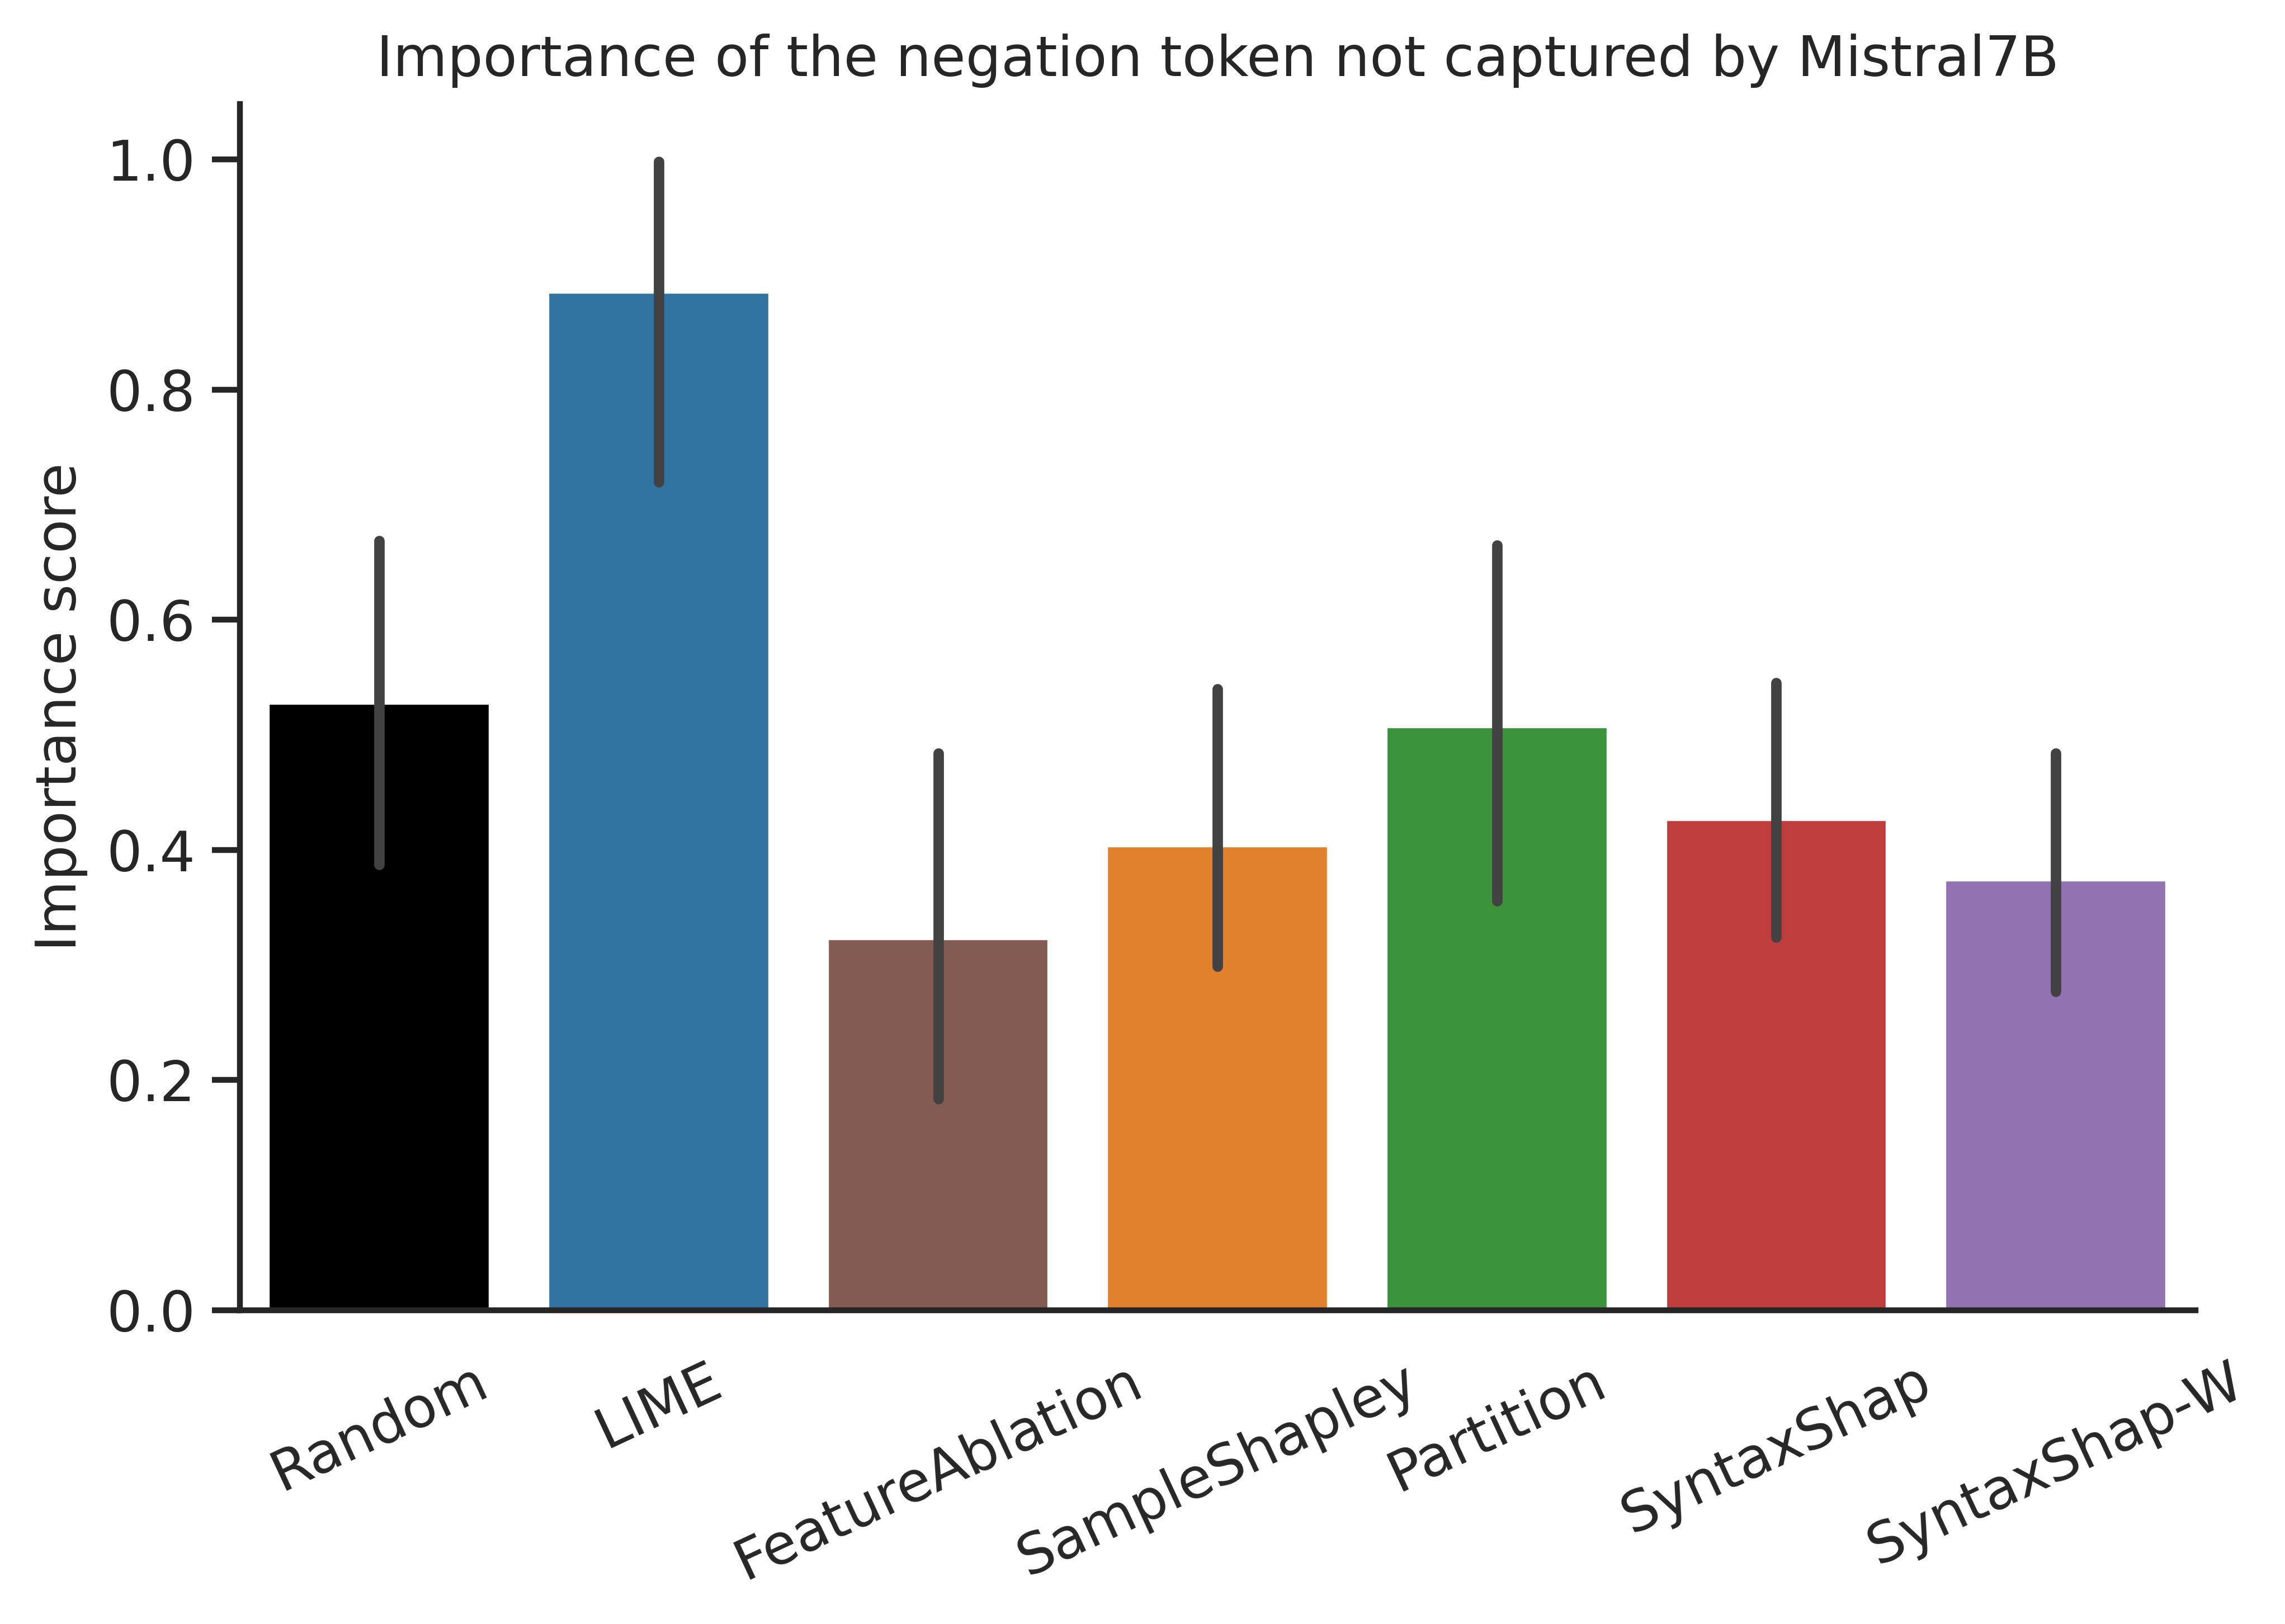

In [23]:
# Plot
df = sample_with_y.copy()
df = df[['algorithm', 'neg_val']]
print(df)

# Define the order of algorithms and a colormap
algo_order = ["random", "lime", "ablation", "svsampling", "hedge", "syntax", "syntax-w"]
pal = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)
df['algorithm'] = df['algorithm'].replace({'lime': 'LIME', 'ablation': 'FeatureAblation', 'svsampling': 'SampleShapley', 'hedge': 'Partition', 'syntax': 'SyntaxShap', 'syntax-w': 'SyntaxShap-W', 'random': 'Random'})
dict_color = {"Random": 'black', "LIME": pal[0], "SampleShapley": pal[1], "Partition": pal[2], "SyntaxShap": pal[3], "SyntaxShap-W": pal[4], "FeatureAblation": pal[5]} 


# Adjusting various parameters
# Plotting with Seaborn
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})


plt.figure(figsize=(7,5))


sns.barplot(data=df, x='algorithm', y='neg_val', hue='algorithm', palette=dict_color)#, errorbar='se')
plt.title('Importance of the negation token not captured by Mistral7B')
plt.ylabel('Importance score')
plt.xlabel('')
plt.xticks(rotation=25)
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=False)
sns.despine()
plt.tight_layout()

plt.savefig(f"{save_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_negation_importance.png", bbox_inches='tight', dpi=600)

      algorithm  neg_rank
0    svsampling         3
1        random         3
2      ablation         2
3      syntax-w         4
4         hedge         3
..          ...       ...
149    ablation         1
150    syntax-w         3
151       hedge         2
152        lime         1
153      syntax         3

[154 rows x 2 columns]


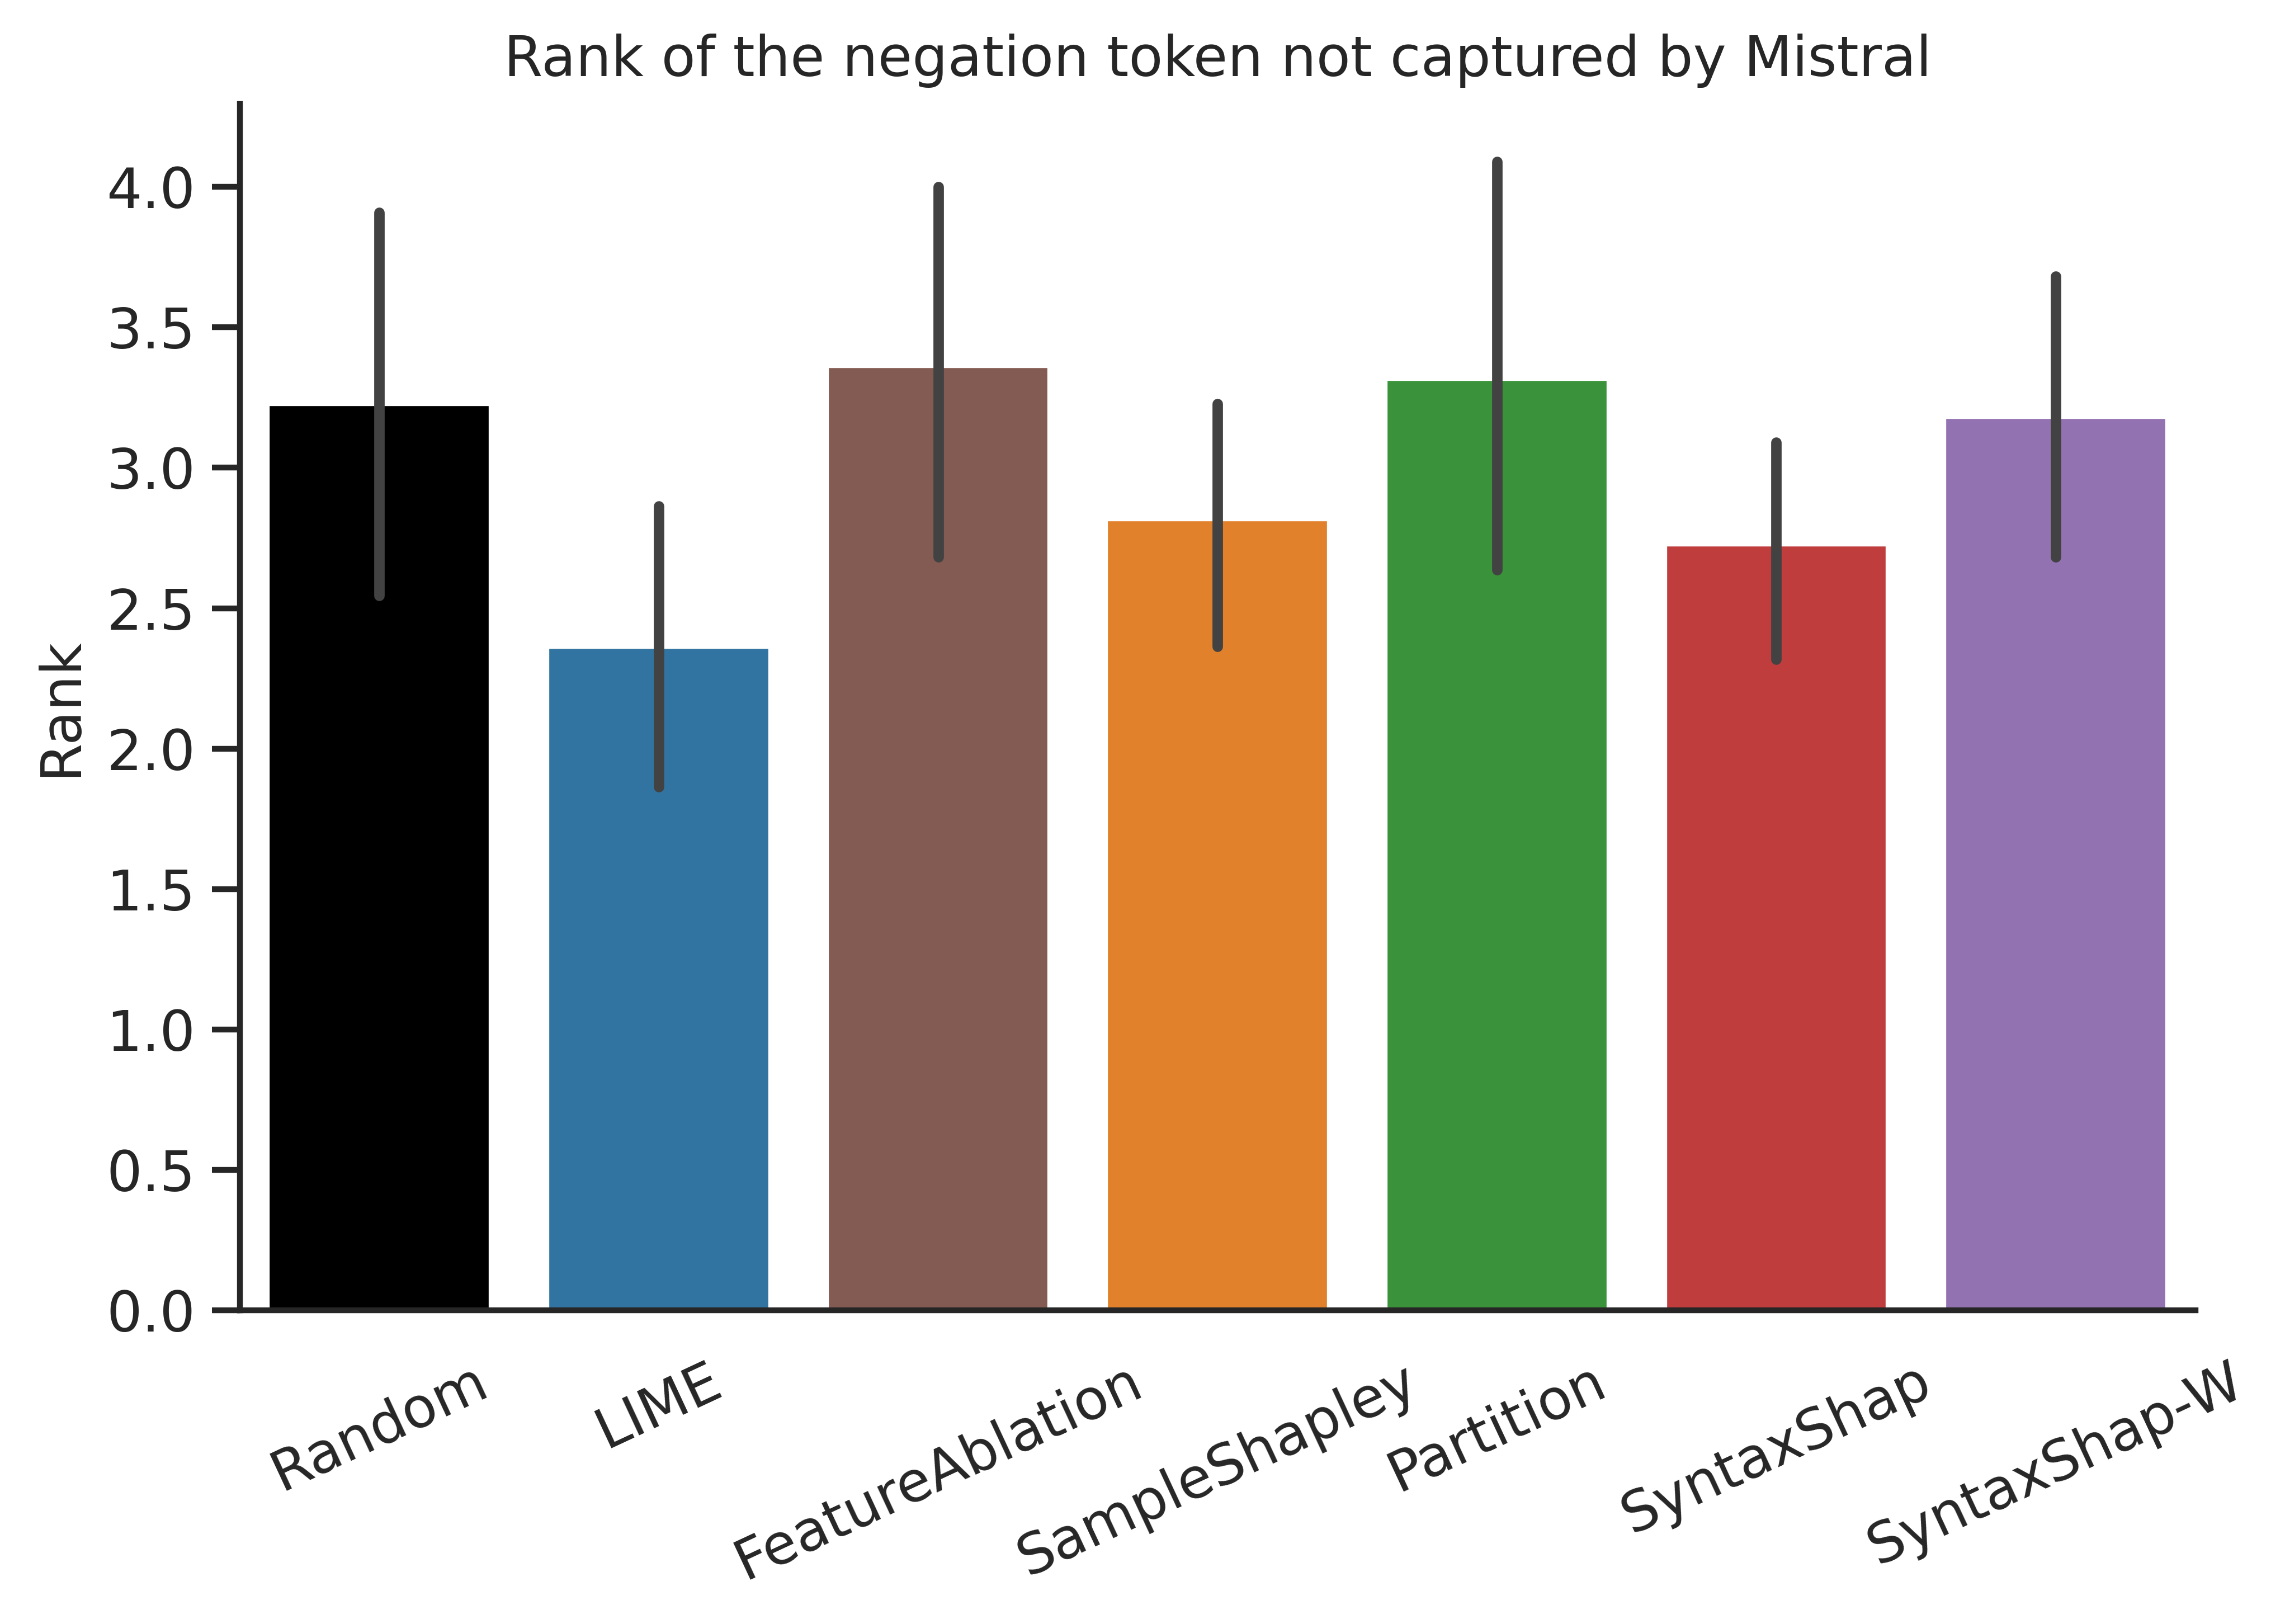

In [24]:
# Plot
df = sample_with_y.copy()
df = df[['algorithm', 'neg_rank']]
print(df)

# Define the order of algorithms and a colormap
algo_order = ["random", "lime", "ablation", "svsampling", "hedge", "syntax", "syntax-w"]
pal = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)
df['algorithm'] = df['algorithm'].replace({'lime': 'LIME', 'ablation': 'FeatureAblation', 'svsampling': 'SampleShapley', 'hedge': 'Partition', 'syntax': 'SyntaxShap', 'syntax-w': 'SyntaxShap-W', 'random': 'Random'})
dict_color = {"Random": 'black', "LIME": pal[0], "SampleShapley": pal[1], "Partition": pal[2], "SyntaxShap": pal[3], "SyntaxShap-W": pal[4], "FeatureAblation": pal[5]} 


# Adjusting various parameters
# Plotting with Seaborn
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})


plt.figure(figsize=(7,5))


sns.barplot(data=df, x='algorithm', y='neg_rank', hue='algorithm', palette=dict_color)#, errorbar='se')
plt.title('Rank of the negation token not captured by Mistral')
plt.ylabel('Rank')
plt.xlabel('')
plt.xticks(rotation=25)
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=False)
sns.despine()
plt.tight_layout()

plt.savefig(f"{save_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_negation_rank.png", bbox_inches='tight', dpi=600)